### **Router**

##### **Review**

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

- Return a tool call
- Return a natural language response

##### **Goals**

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.



In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools([multiply])

We use the **built-in** `ToolNode` and simply pass a list of our tools to initialize it.

We use the **built-in** `tools_condition` as our conditional edge.

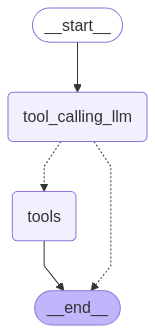

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the last message (result) from assistant is a tool call -> tools_contidition routes to tools
    # If the last message (restult) from assistant is not a tool -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from langchain_core.messages import HumanMessage
from pprint import pprint

messages = [HumanMessage(content="Mutiply 3 and 4.")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Mutiply 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JTr1bX5BJjeorcbhZFxynIYw)
 Call ID: call_JTr1bX5BJjeorcbhZFxynIYw
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.